In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [253]:
#Scikit-learn modules
from sklearn.tree  import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import statistics
import xgboost as xgb

In [39]:
train = pd.read_csv("train-data.csv")
test = pd.read_csv("train-data.csv")

In [40]:
df = pd.concat([train, test], ignore_index=True)

In [41]:
df.isna().sum()

Unnamed: 0               0
Name                     0
Location                 0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  4
Engine                  72
Power                   72
Seats                   84
New_Price            10390
Price                    0
dtype: int64

In [42]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [43]:
location_dict = {
        'Mumbai':(19.07, 72.87),
        'Pune':(18.52, 73.85),
        'Chennai':(13.08, 80.27),
        'Coimbatore':(11.01, 76.95),
        'Hyderabad': (17.38, 78.48),
        'Jaipur':(26.91, 75.78),
        'Kochi':(9.93, 76.26),
        'Kolkata':(22.57, 88.36),
        'Delhi':(28.70, 77.10),
        'Bangalore':(12.97, 77.59),
        'Ahmedabad':(23.02, 72.57)
        }

def preprocess(x):
    cc_str = str(x["Engine"])[:-3]
    if cc_str != "":
        x["Engine"] = int(cc_str)
    # 0 is out of domain
    # 0 will change with median
    
    tmp = x["Name"].split()
    x["Brand"] = tmp[0]
    x["Model"] = tmp[1]
    
    tmp = location_dict[x["Location"]]
    x["Longitude"] = tmp[0]
    x["Latitude"] = tmp[1]
    
    if x["Power"] != "" and x["Power"] != "null bhp":
        power_str = str(x["Power"]).split()[0]
        x["Power"] = float(power_str)
    else: x["Power"] = 0
    
    if x["Mileage"] != "":
        power_str = str(x["Mileage"]).split()[0]
        x["Mileage"] = float(power_str)
    else: x["Mileage"] = 0
    
    x["Age"] = 2019 - x["Year"]
    
    if x["Owner_Type"] == "First":
        x["Owner_Type"] = 1
    elif x["Owner_Type"] == "Second":
        x["Owner_Type"] = 2
    elif x["Owner_Type"] == "Third":
        x["Owner_Type"] = 3
    elif x["Owner_Type"] == "Fourth & Above":
        x["Owner_Type"] = 4
        
    if x["Fuel_Type"] == "CNG" or x["Fuel_Type"] == "LPG":
        x["Fuel_Type"] = "Gas"
    return x

In [44]:
df = df.apply(preprocess, axis=1)
df.drop(columns=["Name", "Location", "Unnamed: 0", "Year", "New_Price"], inplace=True)

In [45]:
df

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,72000,Gas,Manual,1,26.60,998.0,58.16,5.0,1.75,Maruti,Wagon,19.07,72.87,9
1,41000,Diesel,Manual,1,19.67,1582.0,126.20,5.0,12.50,Hyundai,Creta,18.52,73.85,4
2,46000,Petrol,Manual,1,18.20,1199.0,88.70,5.0,4.50,Honda,Jazz,13.08,80.27,8
3,87000,Diesel,Manual,1,20.77,1248.0,88.76,7.0,6.00,Maruti,Ertiga,13.08,80.27,7
4,40670,Diesel,Automatic,2,15.20,1968.0,140.80,5.0,17.74,Audi,A4,11.01,76.95,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12033,27365,Diesel,Manual,1,28.40,1248.0,74.00,5.0,4.75,Maruti,Swift,28.70,77.10,5
12034,100000,Diesel,Manual,1,24.40,1120.0,71.00,5.0,4.00,Hyundai,Xcent,26.91,75.78,4
12035,55000,Diesel,Manual,2,14.00,2498.0,112.00,8.0,2.90,Mahindra,Xylo,26.91,75.78,7
12036,46000,Petrol,Manual,1,18.90,998.0,67.10,5.0,2.65,Maruti,Wagon,22.57,88.36,6


In [46]:
df.drop(df[df["Kilometers_Driven"] == df["Kilometers_Driven"].max()].index, inplace=True)
df.drop(df[df["Fuel_Type"] == "Electric"].index, inplace=True)

In [294]:
def fill_median(x):
    # na is replaced with 0 previously
    if x["Power"] == 0:
        x["Power"] = train["Power"].median()

    if x["Mileage"] == 0:
        x["Mileage"] = train["Mileage"].median()
    
    return x
train = train.apply(fill_median, axis=1)

In [47]:
trans_le = LabelEncoder()
df["Transmission"] = trans_le.fit_transform(df["Transmission"])

ft_le = LabelEncoder()
df["Fuel_Type"] = ft_le.fit_transform(df["Fuel_Type"])

brand_le = LabelEncoder()
df["Brand"] = brand_le.fit_transform(df["Brand"])

model_le = LabelEncoder()
df["Model"] = model_le.fit_transform(df["Model"])

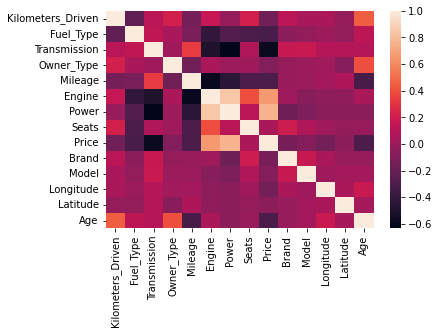

In [100]:
figure = sns.heatmap(df.corr())
# Power and engine has a great correlation can be used together
# Curse of dimensionality can be avoided

In [53]:
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [54]:
df_scaled

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,0.378244,0.076777,0.631977,-0.444686,1.847294,-1.037315,-0.957299,-0.344737,-0.691263,0.331409,1.229914,0.182624,-1.084610,1.026889
1,-0.440100,-0.931714,0.631977,-0.444686,0.334922,-0.065368,0.270238,-0.344737,0.271423,-0.662364,-0.839873,0.089273,-0.844843,-0.502336
2,-0.308109,1.085267,0.631977,-0.444686,0.014115,-0.702792,-0.406314,-0.344737,-0.444994,-0.786585,-0.144795,-0.834060,0.725875,0.721044
3,0.774217,-0.931714,0.631977,-0.444686,0.574981,-0.621241,-0.405232,2.127601,-0.310666,0.331409,-0.608180,-0.834060,0.725875,0.415199
4,-0.448811,-0.931714,-1.582336,1.746332,-0.640591,0.577049,0.533643,-0.344737,0.740676,-1.780358,-1.504058,-1.185402,-0.086397,0.109354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12027,-0.800039,-0.931714,0.631977,-0.444686,2.240118,-0.621241,-0.671523,-0.344737,-0.422606,0.331409,0.920991,1.817127,-0.049698,-0.196491
12028,1.117393,-0.931714,0.631977,-0.444686,1.367176,-0.834271,-0.725647,-0.344737,-0.489770,-0.662364,1.430714,1.513310,-0.372649,-0.502336
12029,-0.070525,-0.931714,0.631977,1.746332,-0.902474,1.459124,0.014050,3.363771,-0.588278,0.207187,1.461606,1.513310,-0.372649,0.415199
12030,-0.308109,1.085267,0.631977,-0.444686,0.166880,-1.037315,-0.796009,-0.344737,-0.610666,0.331409,1.229914,0.776680,2.705176,0.109354


In [179]:
df["Mileage"] = df["Mileage"].fillna(df["Mileage"].median())

In [306]:
train.isna().sum()

Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
Brand                 0
Model                 0
Longitude             0
Latitude              0
Age                   0
dtype: int64

In [55]:
imputer = KNNImputer(n_neighbors=1)
imputed_data = imputer.fit_transform(df_scaled)  # impute all the missing data
df_temp = pd.DataFrame(imputed_data)
df_temp.columns = df_scaled.columns
# df_x[2] = df_temp[2] # make changes only for specific column
df_temp.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
Model                0
Longitude            0
Latitude             0
Age                  0
dtype: int64

In [318]:
imputed_data = imputer.transform(test)
df_temp_test = pd.DataFrame(imputed_data)
df_temp_test.columns = train.columns
df_temp_test.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
Model                0
Longitude            0
Latitude             0
Age                  0
dtype: int64

In [261]:
X, y = df_temp.drop(columns="Price"), df_temp["Price"]

In [57]:
bin_num = 6
y_binned = pd.qcut(y, q=bin_num, labels=np.arange(bin_num))

In [102]:
X_train, X_test, y_binned_train, y_binned_test = train_test_split(X, y_binned, test_size = 0.3, random_state = 42, shuffle = True)

# Decision Tree

In [263]:
dt = DecisionTreeRegressor(min_samples_leaf=50, random_state=42)

In [264]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=50, random_state=42)

In [265]:
dt.score(X_test, y_test)

0.7945207985723167

In [266]:
mean_squared_error(dt.predict(X_test), y_test)

0.20001602733832727

# Random Forest

In [259]:
reg = RandomForestRegressor(max_depth=30, random_state=42)
reg.fit(X_train, y_train)
y_pred = clf.predict(X_test)
reg.score(X_test, y_test)

0.0455446484498858

In [260]:
mean_squared_error(y_pred, y_test)

0.0455446484498858

In [116]:
rf_scores = dict()
for i in range(1, 40):
    clf = RandomForestClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_binned_train)
    rf_scores[i] = clf.score(X_test, y_binned_test)

Text(0, 0.5, 'Classification Score')

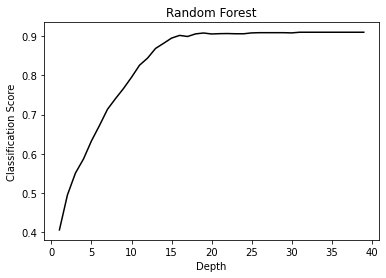

In [235]:
plt.plot(rf_scores.keys(), rf_scores.values(), color="black")
plt.title("Random Forest")
plt.xlabel("Depth")
plt.ylabel("Classification Score")

# XGBOOST

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [228]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [229]:
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [230]:
xgbr.score(X_test, y_test)

0.9750858169554163

In [251]:
y_test, y_pred

(4412    -0.575741
 10474   -0.686785
 5032    -0.601711
 2611     0.723661
 1562     3.450523
            ...   
 5608    -0.758427
 1765    -0.588278
 5496    -0.552457
 2456    -0.570367
 5665    -0.669770
 Name: Price, Length: 3610, dtype: float64,
 array([-0.594171  , -0.56262094, -0.68631893, ..., -0.55902034,
        -0.50409263, -0.6885315 ], dtype=float32))

In [231]:
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [232]:
mse

0.024251777709537913

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

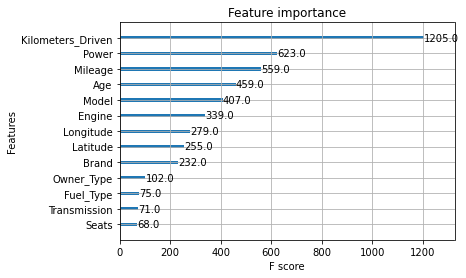

In [233]:
xgb.plot_importance(xgbr)

# XGBOOST with PCA

In [236]:
mse = dict()
score = dict()
for n in range(1, 13):
    pca = PCA(n_components = n)
    pca.fit(X)

    X_pca = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 42, shuffle = True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgbr = xgb.XGBRegressor(verbosity=0) 
    xgbr.fit(X_train, y_train)
    score[n] = xgbr.score(X_test, y_test)
    y_pred = xgbr.predict(X_test)
    mse[n] = mean_squared_error(y_test, y_pred)
    

Text(0.5, 1.0, 'PCA')

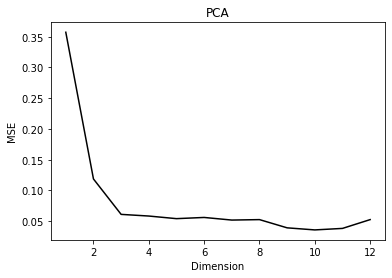

In [241]:
plt.plot(mse.keys(), mse.values(), color="black")
plt.xlabel("Dimension")
plt.ylabel("MSE")
plt.title("PCA")